In [46]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import Formatter
import datetime as dt
import pandas as pd

from stable_baselines.common.policies import MlpLstmPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.ppo2 import PPO2
from stable_baselines import bench, logger
from stable_baselines.results_plotter import load_results, ts2xy

from importlib import reload
from time import time
import os.path

## Load Utilities

In [47]:
from utils.evaluator import Evaluator
from utils.formatter import DateFormatter

evaluator = Evaluator()

## Load Environment

In [48]:
from envs import equity_env

In [49]:
env = equity_env.EquityEnv(split_data=True)
env = DummyVecEnv([lambda: env])

-- Data Loaded --
-- Environment Created --


## Initialize Model

In [50]:
model = PPO2(MlpLstmPolicy, env, n_steps=240, learning_rate=0.000001, verbose=0, nminibatches=1, 
             policy_kwargs={"n_lstm":36, "layers":[36,36]}, tensorboard_log="./outputs/equity_train_tensorboard/")

/usr/local/lib/python3.5/dist-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


## Train Model for 100 episodes

In [51]:
start = time()
model.learn(total_timesteps=100, tb_log_name="0bps_new_env")
end = time()
t = end - start
print("Takes %d s to run" % t)

Takes 1 s to run


## Hyper-parameter tuning

In [52]:
import optunity

In [53]:
dev_env = equity_env.EquityEnv(split_data=False, test_option="develop")
dev_env = DummyVecEnv([lambda: dev_env])

-- Data Loaded --
-- Environment Created --


In [54]:
search = {"episode_len": {"120": {"ent_coef": [0.01, 0.1],
                                  "vf_coef": [0.3, 0.8],
                                  "cliprange": [0.1, 0.5],
                                  "learning_rate": [1e-7, 1e-3],
                                  "n_lstm": [8, 256]},
                          "480": {"ent_coef": [0.01, 0.1],
                                  "vf_coef": [0.3, 0.8],
                                  "cliprange": [0.1, 0.5],
                                  "learning_rate": [1e-7, 1e-3],
                                  "n_lstm": [8, 256]}, 
                          "1200": {"ent_coef": [0.01, 0.1],
                                  "vf_coef": [0.3, 0.8],
                                  "cliprange": [0.1, 0.5],
                                  "learning_rate": [1e-7, 1e-3],
                                  "n_lstm": [8, 256]}}}

In [55]:
def performance(episode_len, ent_coef, vf_coef, cliprange, learning_rate, n_lstm):
    ep_len = int(episode_len)
    env = equity_env.EquityEnv(split_data=True, episode_length=ep_len)
    env = DummyVecEnv([lambda: env])
    model = PPO2(MlpLstmPolicy, env, n_steps=240, ent_coef=ent_coef, vf_coef=vf_coef,
                 cliprange=cliprange, learning_rate=learning_rate, verbose=0, 
                 nminibatches=1, policy_kwargs={"n_lstm":int(n_lstm), "layers":[36,36]})
    episode_num = int(200 / (ep_len / 120))
    model.learn(total_timesteps=ep_len*episode_num)        
    return evaluator.evaluate_short(model, dev_env)

In [ ]:
t = time()
result = performance("1", 0.01, 0.5, 0.2, 1e-4, 36)
print("Takes %d s to run" % (time() - t))

-- Data Loaded --
-- Environment Created --


/usr/local/lib/python3.5/dist-packages/stable_baselines/common/policies.py:415: UserWarning: The layers parameter is deprecated. Use the net_arch parameter instead.
  warnings.warn("The layers parameter is deprecated. Use the net_arch parameter instead.")


In [ ]:
result

#### warning: the following two chunks of code can take a long time to run. 

In [ ]:
optimal_configuration, info, _ = optunity.maximize_structured(performance, search_space=search, num_evals=50)

In [ ]:
model = PPO2(MlpLstmPolicy, env, n_steps=240, ent_coef=0.01, vf_coef=0.5,
             cliprange=0.2, learning_rate=1e-5, verbose=0, 
             nminibatches=1, policy_kwargs={"n_lstm":36, "layers":[36,36]})

pnl, dates, trans_cost, actions = evaluator.evaluate(model, dev_env)

In [ ]:
evaluator.annual_sharpe(pnl)

In [ ]:
evaluator.annual_return(pnl)

In [ ]:
evaluator.annual_volatility(pnl)

In [ ]:
evaluator.maximum_drawdown(pnl)

In [ ]:
evaluator.annual_turnover(actions)

## Construct Baseline Strategies

In [33]:
prices = pd.read_csv("data/price.csv", parse_dates=[0])
dates = prices.iloc[:,0].apply(lambda x: pd.to_datetime(x))
principal = 1000000

### 1. Momentum Strategy

In [34]:
# First, need to get return. need to define a look back period
def momentum_signal(price_data, look_back, normalize=True):
    price_data = prices.iloc[:, [2,4,6]].values
    delay_price = np.roll(price_data, look_back, axis=0)
    delay_price[:look_back] = np.nan
    mom_sig = (price_data - delay_price) / delay_price
    if normalize:
        mom_sig = mom_sig - mom_sig.mean(axis=1,keepdims=True)
        mom_sig = mom_sig / ((mom_sig > 0) * mom_sig).sum(axis=1, keepdims=True)
    return mom_sig

ret1 = momentum_signal(prices, 1, False)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


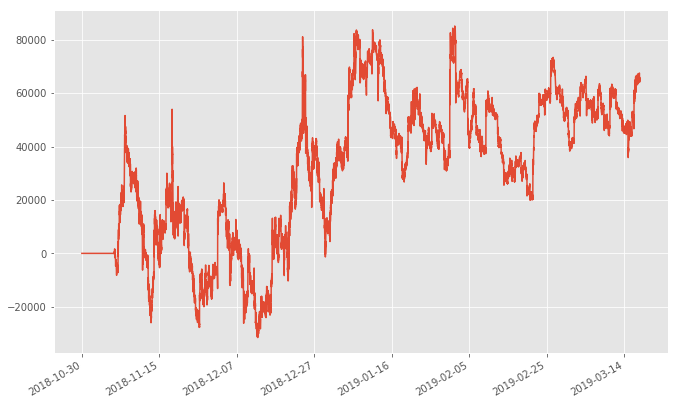

0.6869607785215986


In [35]:
mom = momentum_signal(prices, 2100)

pnl_mom = np.sum(mom * np.roll(ret1, -1, axis=0), axis=1) * principal
pnl_mom = np.nan_to_num(pnl_mom)

plt.style.use("ggplot")
formatter = DateFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_mom.shape[0]), np.cumsum(pnl_mom))
fig.autofmt_xdate()
plt.show()

print(evaluator.annual_sharpe(pnl_mom))

### 2. Buy-and-hold Strategy

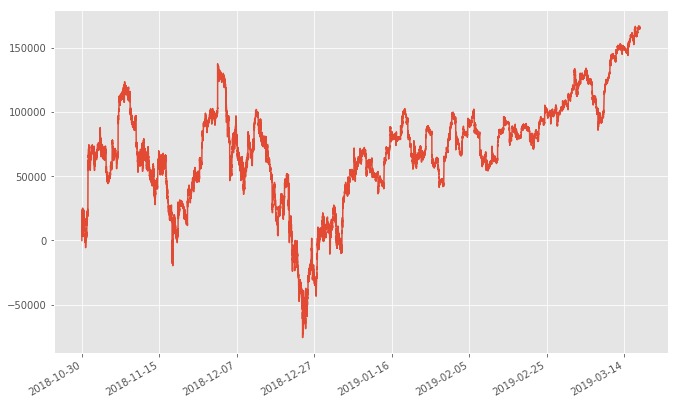

1.4030214749563588


In [36]:
mut = ret1+1
mut[0] = 1
pnl_hold = np.sum((np.cumprod(mut, axis=0)-1) / 3 * principal, axis=1)
pnl_hold = pnl_hold - np.roll(pnl_hold, 1)
pnl_hold[0] = 0
plt.style.use("ggplot")
formatter = DateFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_hold.shape[0]), np.cumsum(pnl_hold))
fig.autofmt_xdate()
plt.show()

print(evaluator.annual_sharpe(pnl_hold))

### 3. Compare RL with the baseline strategies

In [37]:
import pickle

In [38]:
with open("outputs/model_pnl_35000.dms", "rb") as f:
    pnl_ppo = pickle.load(f)

In [39]:
n = pnl_ppo.shape[0]
pnl_mom = pnl_mom[:n]
pnl_hold = pnl_hold[:n]

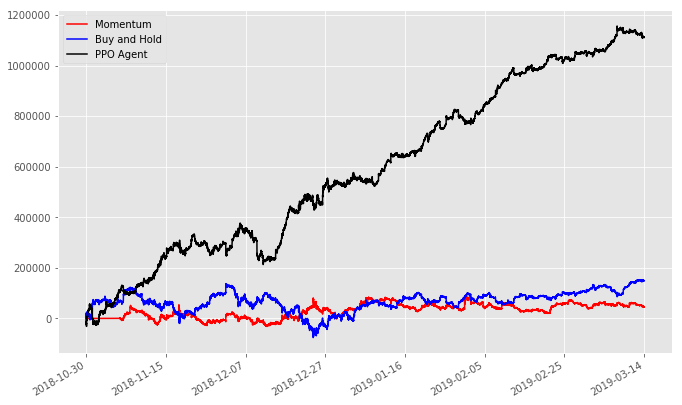

In [40]:
plt.style.use("ggplot")
formatter = DateFormatter(dates)
fig, ax = plt.subplots(figsize=(11, 7))
ax.xaxis.set_major_formatter(formatter)
ax.plot(np.arange(pnl_mom.shape[0]), np.cumsum(pnl_mom), c="r", label="Momentum")
ax.plot(np.arange(pnl_hold.shape[0]), np.cumsum(pnl_hold), c="b", label="Buy and Hold")
ax.plot(np.arange(pnl_ppo.shape[0]), np.cumsum(pnl_ppo), c="k", label="PPO Agent")
fig.autofmt_xdate()
plt.legend()
plt.show()

In [41]:
evaluator.annual_sharpe(pnl_ppo)

7.738935430798078

In [42]:
evaluator.annual_return(pnl_ppo)

3.1184817582615683

In [43]:
evaluator.annual_volatility(pnl_ppo)

0.020435816070433228

In [44]:
evaluator.annual_turnover(pnl_ppo)

109629239.616

In [45]:
evaluator.maximum_drawdown(pnl_ppo)

0.43500876